# 对抗训练

In [1]:
import os
import torch
from torch import nn, optim
from tqdm import tqdm
import torchvision

import utils

white_1_model_dict_path = "./white_model_1.pt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## 加载之前训练的的白盒模型

In [2]:
net1 = utils.white_model()
net1.to(device)
net1.load_state_dict(torch.load(white_1_model_dict_path))

In [3]:
batch_size = 256
train_iter, test_iter = utils.load_data_fashion_mnist(batch_size=batch_size)

print("原白盒模型测试集准确率: ", utils.evaluate_accuracy(test_iter, net1))

原白盒模型测试集准确率:  0.9197


## 从训练集中选出1000张能被正确分类的样本

In [4]:
net1.eval()
X_train, y_train = utils.select_right_sample(net1, train_iter, 1000)

assert (net1(X_train.to(device)).argmax(dim=1) == y_train.to(device)).float().sum().cpu().item() == 1000.0

## 对选出的1000个训练样本进行对抗攻击

In [5]:
attack_lr, max_attack_step = 0.01, 50
before_atk_y, after_atk_X, after_atk_y = [], [], []
for i in tqdm(range(1000)):
    X_, y_, success = utils.white_box_attack(net1, X_train[i:i+1], y_train[i:i+1], attack_lr, max_attack_step)
    if success:
        before_atk_y.append(y_train[i])
        after_atk_X.append(X_[0])
        after_atk_y.append(y_[0])
print("学习率%.3f,最大步长%d的白盒攻击成功率: %.2f%%" % (attack_lr, max_attack_step, len(after_atk_y) / 10))

100%|██████████| 1000/1000 [00:34<00:00, 28.58it/s]

学习率0.010,最大步长50的白盒攻击成功率: 98.50%


## 将对抗样本掺入训练集中

In [6]:
def new_train_iter(batch_size, img_list, label_list, root='~/Datasets/FashionMNIST'): 
    transform = torchvision.transforms.ToTensor()
    mnist_train = torchvision.datasets.FashionMNIST(root=root, train=True, download=True, transform=transform)
    
    extra_dataset = torch.utils.data.TensorDataset(torch.stack(img_list), torch.stack(label_list))
    dataset = torch.utils.data.ConcatDataset([mnist_train, extra_dataset])
    print("添加对抗样本后的训练集大小:", len(dataset))
    num_workers = 4
    train_iter = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    return train_iter

In [7]:
new_train_iter = new_train_iter(batch_size, after_atk_X, before_atk_y)

添加对抗样本后的训练集大小: 60985


## 用新训练集重新训练一个白盒模型

In [8]:
net2 = utils.white_model()
net2.to(device)
lr, num_epochs = 0.001, 10
optimizer = torch.optim.Adam(net2.parameters(), lr=lr)
utils.train(net2, new_train_iter, test_iter, batch_size, optimizer, device, num_epochs)

training on  cuda
epoch 1, loss 0.0021, train acc 0.804, test acc 0.873, time 2.9 sec
epoch 2, loss 0.0013, train acc 0.883, test acc 0.882, time 2.9 sec
epoch 3, loss 0.0011, train acc 0.901, test acc 0.894, time 2.9 sec
epoch 4, loss 0.0009, train acc 0.912, test acc 0.904, time 2.8 sec
epoch 5, loss 0.0009, train acc 0.920, test acc 0.909, time 2.9 sec
epoch 6, loss 0.0008, train acc 0.928, test acc 0.913, time 2.9 sec
epoch 7, loss 0.0007, train acc 0.933, test acc 0.917, time 3.2 sec
epoch 8, loss 0.0006, train acc 0.939, test acc 0.921, time 2.9 sec
epoch 9, loss 0.0006, train acc 0.946, test acc 0.918, time 3.1 sec
epoch 10, loss 0.0005, train acc 0.952, test acc 0.920, time 3.1 sec


## 对新的白盒模型进行白盒对抗攻击

100%|██████████| 1000/1000 [00:32<00:00, 30.61it/s]


学习率0.010,最大步数50的白盒攻击成功率: 99.40%
成功样本举例:

攻击前:


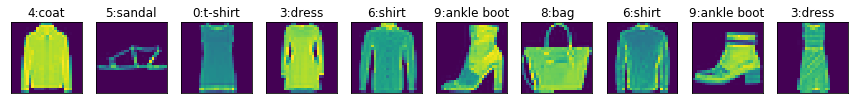

攻击后:


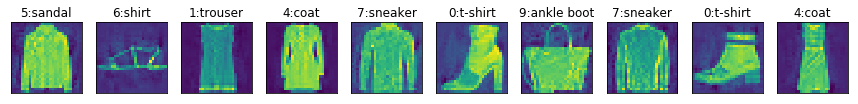

In [9]:
net2.eval()
X_test, y_test = utils.select_right_sample(net2, test_iter)

assert (net2(X_test.to(device)).argmax(dim=1) == y_test.to(device)).float().sum().cpu().item() == 1000.0

attack_lr, max_attack_step = 0.01, 50
before_atk_X, before_atk_y = [], []
after_atk_X, after_atk_y = [], []
for i in tqdm(range(1000)):
    X_, y_, success = utils.white_box_attack(net2, X_test[i:i+1], y_test[i:i+1], attack_lr, max_attack_step)
    if success:
        before_atk_X.append(X_test[i])
        before_atk_y.append(y_test[i])
        after_atk_X.append(X_)
        after_atk_y.append(y_)
print("学习率%.3f,最大步数%d的白盒攻击成功率: %.2f%%" % (attack_lr, max_attack_step, len(after_atk_y) / 10))
print("成功样本举例:\n")
print("攻击前:")
utils.show_fashion_mnist(before_atk_X[:10], utils.get_fashion_mnist_labels(before_atk_y[:10]))
print("攻击后:")
utils.show_fashion_mnist(after_atk_X[:10], utils.get_fashion_mnist_labels(after_atk_y[:10]))

## 对新的白盒模型进行黑盒对抗攻击

In [10]:
def apply_black_attack(net, right_X, right_y, attack_sigma = 0.01, max_attack_step = 100):
    before_atk_X, before_atk_y = [], []
    after_atk_X, after_atk_y = [], []
    for i in tqdm(range(len(right_y))):
        X_, y_, success = utils.black_box_attack(net, right_X[i:i+1], right_y[i:i+1], attack_sigma, max_attack_step)
        if success:
            before_atk_X.append(right_X[i])
            before_atk_y.append(right_y[i])
            after_atk_X.append(X_)
            after_atk_y.append(y_)
    print("标准差%.3f,最大步数%d的MCMC黑盒攻击成功率: %.2f%%" % (attack_sigma, max_attack_step, len(after_atk_y) / (len(right_y) / 100) ))
    show_num = min(10, len(after_atk_y))
    print("成功样本举例:\n")
    print("攻击前:")
    utils.show_fashion_mnist(before_atk_X[:show_num], utils.get_fashion_mnist_labels(before_atk_y[:show_num]))
    print("攻击后:")
    utils.show_fashion_mnist(after_atk_X[:show_num], utils.get_fashion_mnist_labels(after_atk_y[:show_num]))

100%|██████████| 1000/1000 [01:39<00:00, 10.05it/s]


标准差0.050,最大步数100的MCMC黑盒攻击成功率: 5.10%
成功样本举例:

攻击前:


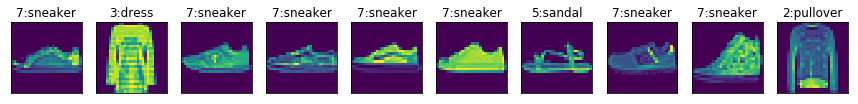

攻击后:


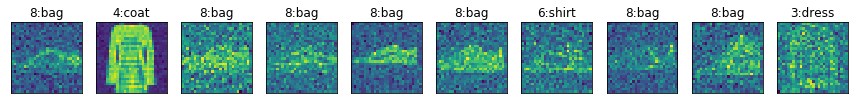

In [14]:
net2.eval()
X_test, y_test = utils.select_right_sample(net2, test_iter)

assert (net2(X_test.to(device)).argmax(dim=1) == y_test.to(device)).float().sum().cpu().item() == 1000.0
apply_black_attack(net2, X_test, y_test, attack_sigma = 0.05, max_attack_step = 100)